# Movie Recommedation System
#### Peixuan Song - Group 9

## Dataset

MovieLens Latest Datasets(ml-latest-small) dataset from [MovieLens](https://grouplens.org/datasets/movielens/)

The dataset contains 100,836 5-star based ratings for 9,742 movies given by 610 users. 
These data were created between March 29, 1996 and September 24, 2018.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [4]:
#100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.
#links=pd.read_csv('data/links.csv')
#tags=pd.read_csv('data/tags.csv')
ratings=pd.read_csv('.././data/ratings.csv')
movies=pd.read_csv('.././data/movies.csv')

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
rating_dict = {}
for i in range(ratings.shape[0]):
    line = ratings.loc[i,:]
    if line.userId in rating_dict:
        rating_dict[line.userId][line.movieId] = line.rating
    else:
        rating_dict[line.userId] = {line.movieId:line.rating}
rating_matrix = pd.DataFrame(rating_dict).T

rating_matrix.to_csv(".././output/rating_matrix.csv")

In [190]:
df=rating_matrix
df.shape #(5,931,640)

(610, 9724)

### Train Test Split

<img src="../figs/table1.png" width="800" height="600">

In [278]:
## select userid:400-610 and movieid:7000-9724 as testing data 
## so the test dataset is a 210*2724 matrix (572,040)
df_train_A=np.array(rating_matrix)
df_test=df_train_A[400:,7000:]
df_test.shape

In [279]:
## training data
df_train=df_train_A.copy()
df_train[400:,7000:]=np.nan
#df_train=np.array(df_train)

In [457]:
# data filled na with 0
df_train_0=np.array(pd.DataFrame(df_train).replace(np.nan,0))
df_test_0=np.array(pd.DataFrame(df_test).replace(np.nan,0))

In [458]:
sum(sum(df_test_0)) ##assert that the test set wasn't na

9800.5

##  Matrix Factorization-based Algorithm

Matrix factorization is a collaborative filtering method to find the relationship between items' and users' entities. The goal of the matrix factorization is to predict rating of user u for item i. 


$$ argmin \sum_{(u,i)\in Z}( R_{ui}-p_{u\cdot}q_{\cdot i})^2 $$



<img src="../figs/fig1.jpeg" width="800" height="600">

### Implementation 1: Fillin R with 0 and Use Singular Value Decomposition to get P, Q

In [276]:
def SVD(train, K):
    df_fill=np.array(pd.DataFrame(train).replace(np.nan,0))
    u,s,v = np.linalg.svd(df_fill,full_matrices=False)
    s0 = np.diag(np.sqrt(s))
    P_0 = np.dot(u,s0)[:,0:K]
    Q_0 = np.dot(s0,v)[0:K,:]
    #print("svd done")
    return P_0,Q_0

### 

### Implementation 2: Matrix Factorization with Penalty



$$ argmin \sum_{(u,i)\in Z^{nm}}( R_{ui}-p_{u\cdot}q_{\cdot i})^2 + \lambda (||p_{u\cdot}||^2+||q_{\cdot i}||^2)$$



### Gradient Descent

- Initializing P, Q
- Update P, Q

$$ P \leftarrow P- \eta*\nabla P$$
$$ Q \leftarrow Q- \eta*\nabla Q$$

update rules:

$$ \nabla P_{u\cdot}=\sum_{a}-2\alpha(R_{ua}-P_{u\cdot}Q_{\cdot a})*Q_{u\cdot}+\lambda P_{u\cdot}$$
$$ \nabla Q_{\cdot i}=\sum_{b} -2\alpha(R_{bi}-P_{b\cdot}Q_{\cdot i})*P_{bi}+\lambda Q_{\cdot i}$$
where:
$ \alpha$ is the learning rate, $\lambda$ is the hyperparameter of the penalizing term

- Get $$ \hat R_{ui}=P_{u\cdot}Q_{\cdot i}$$

In [539]:
def MF_SGD(train,max_iter=1000,lamda=0.00001,K=20,alpha=0.0002):
    loss=[]
    deltacost=[0]
    loss.append(500000)
    P = np.random.rand(train.shape[0],K) #P_init
    Q = np.random.rand(K,train.shape[1])#Q_init#
    for _ in range(max_iter):
        for u in range(train.shape[0]):
            r = np.nonzero(train[u,:] != 0)[0]
            P[u,:]=P[u,:]-2*alpha*(-Q[:,r].dot(train[u,:][r])+Q[:,r].dot(Q[:,r].T).dot(P[u,:])+lamda*P[u,:])
        for i in range(train.shape[1]):
            r = np.nonzero(train[:,i] != 0)[0]
            Q[:,i]=Q[:,i]-2*alpha*(-P[r,:].T.dot(train[:,i][r])+P[r,:].T.dot(P[r,:]).dot(Q[:,i])+lamda*Q[:,i])
        cost = 0
        predR = np.dot(P,Q)
        cost += np.sum((train - predR * (train!=0))**2)
        cost += lamda * (np.sum(P**2)+np.sum(Q**2))#(np.linalg.norm(P[u,:])**2 + np.linalg.norm(Q[:,i])**2)
        loss.append(cost)
        deltaf=(abs(loss[_+1]-loss[_])/loss[_])
        deltac=0.5*deltacost[_]+0.5*deltaf
        deltacost.append(deltac)
        #if _%500 == 0:
            #print()
            #print("num_iter:{},cost:{}".format(_,cost))
            #predData = P.dot(Q)
        if (deltac)<0.00001 and _!=0:
            #print("num_iter:{},cost:{}".format(_,cost))
            break
    return P,Q,cost,loss

## Evaluation and Parameters

In [184]:
def RMSE(P,Q,test):
    ## Input
    # P: estimates of user matrix. 
    # Q: eatimates of movie(item) matrix
    # test: test dataset
    test_0=np.array(pd.DataFrame(test).replace(np.nan,0))
    u=df_train_A.shape[0]-test.shape[0]
    i=df_train_A.shape[1]-test.shape[1]
    PR=(test_0-np.dot(P[u:,],Q[:,i:]))
    mask = 1 - 1*np.isnan(test) #mask matrix to indentify the na of test
    rmse=np.sqrt(sum(sum(np.square(mask*PR)))/sum(sum(mask)))
    return rmse

In [516]:
def rmse_plot(Rmse,names): 
    x_axis=np.arange(1,13,1)
    colors=['skyblue','blue','steelblue']
    for i in range(len(Rmse)):
        plt.plot(x_axis, Rmse[i],  color=colors[i], label=names[i])
    plt.legend() 
    plt.xlabel('feature numbers: K')
    plt.ylabel('RMSE')
    plt.show()

### RMSE of MF v.s SVD

In [503]:
## rmse1 : rmse using svd when K=[1,2,3,4,5,6,7,8,9,10,11,12]
## rmse2 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.0002
##
#rmse1=[]
#for i in range(1,13):
#    P_,Q_=SVD(df_train,i)
#    rmse1.append(RMSE(P_,Q_,df_test))
#print(rmse1)

##max_iter=1000
##lamda=0.005
##K=[1,2,3,4,5,6,7,8,9,10,11,12]
#rmse2=[]
#for i in range(1,13):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.005,K=i,alpha=0.0002)
#    rmse2.append(RMSE(P,Q,df_test))
#    print(rmse2)

[3.2190776837290884, 3.2181814034772334, 3.216611717344716, 3.216189284665354, 3.2155803079263965, 3.2152597943789556, 3.215365229946759, 3.2164388312558936, 3.21574749131929, 3.215723739483833, 3.215889826203359, 3.2162946939482273]
[1.976005120084141, 1.5972574794939427, 1.462750786114886, 1.3399593296881098, 1.2783006398379584, 1.231364458499963, 1.2234675876161099, 1.259489764114092, 1.2993979316042485, 1.3323002403342494, 1.362792630938542, 1.4447259772173908]


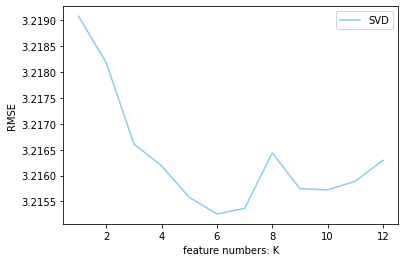

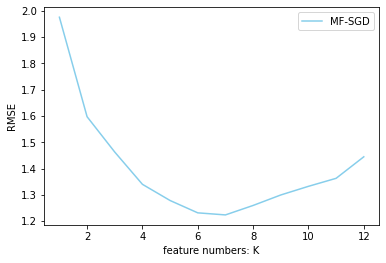

In [533]:
rmse_plot([rmse1],['SVD'])
rmse_plot([rmse2],['MF-SGD'])

### K v.s. iterations

In [546]:
rmse_df=pd.read_csv('./output/rmse_df.csv')
rmse1=rmse_df.rmse1
rmse2=rmse_df.rmse2
rmse3=rmse_df.rmse3
rmse4=rmse_df.rmse4
rmse5=rmse_df.rmse5
rmse6=rmse_df.rmse6
rmse7=rmse_df.rmse7

In [517]:
## rmse2 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.0002
## rmse3 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=3000,lamda=0.005,alpha=0.0002
## 
## max_iter=3000
## lamda=0.005
## K=[1,2,3,4,5,6,7,8,9,10,11,12]
#rmse3=[]
#for i in range(1,16):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=3000,lamda=0.005,K=i,alpha=0.0002)
#    rmse3.append(RMSE(P,Q,df_test))
#    print(rmse3)


[1.964741617904242, 1.6242170486743868, 1.4710460848169828, 1.3822379375144727, 1.3559645844068484, 1.288470775876769, 1.2660150489402127, 1.3179085517253122, 1.3362044588449273, 1.3923543570943504, 1.475947887741152, 1.519896935803565]


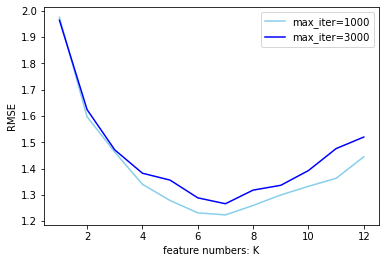

In [547]:
rmse_plot([rmse2,rmse3],['max_iter=1000','max_iter=3000'])

### K v.s. lambda

In [520]:
## lambda=[0.0005,0.005,0.01]
## rmse2 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.0002
## rmse4 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.0005,alpha=0.0002
## rmse6 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.01,alpha=0.0002

## lambda=0.0005
## K=[1,2,3,4,5,6,7,8,9,10,11,12]
#rmse4=[]
#for i in range(1,13):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.0005,K=i,alpha=0.0002)
#    rmse4.append(RMSE(P,Q,df_test))
#    print(rmse4) # MF-SGD lambda=0.0005,K=10,alpha=0.0002

## lambda=0.01
## K=[1,2,3,4,5,6,7,8,9,10,11,12]
#rmse6=[]
#for i in range(1,13):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.01,K=i,alpha=0.0002)
#    rmse6.append(RMSE(P,Q,df_test))
#    print(rmse6) # MF-SGD lambda=0.01,K=10,alpha=0.0002


[1.943309506745084, 1.9957263212009704, 1.9681401282462112, 1.5971644928695155, 1.6246692211352334, 1.6247086049836326, 1.4702301997014446, 1.4320608591352562, 1.4497943042276977, 1.3237344180049857, 1.3367127147132996, 1.4589539364273865]
[1.9687126342863668, 1.6349568092774502, 1.4549864339428642, 1.3411417423702625, 1.2676570900006203, 1.249883750646665, 1.2283117820485843, 1.216571806636367, 1.2764004322745173, 1.3447885520478986, 1.4417056973467697, 1.529808383593084]


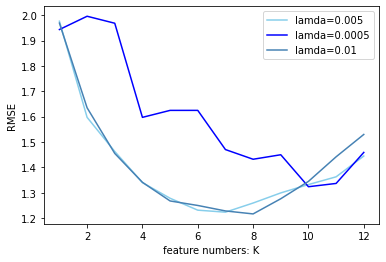

In [521]:
rmse_plot([rmse2,rmse4,rmse6],['lamda=0.005','lamda=0.0005','lamda=0.01'])

### K v.s. alpha

In [553]:
#alpha=[0.00005,0.0001,0.0002]
## rmse2 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.0002
## rmse5 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.00005
## rmse7 : rmse using MF-SGD when K=[1,2,3,4,5,6,7,8,9,10,11,12],max_iter=1000,lamda=0.005,alpha=0.0001


#rmse5=[]
#for i in range(1,13):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.005,K=i,alpha=0.00005)
#    rmse5.append(RMSE(P,Q,df_test))
print(rmse5)

#rmse6=[]
#for i in range(1,13):
#    P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.005,K=i,alpha=0.0001)
#    rmse6.append(RMSE(P,Q,df_test))
print(rmse7)

[2.0089886716188667, 1.6452166802474844, 1.4185397671267217, 1.3249684067053111, 1.2443653518302098, 1.2175810313674242, 1.1608141984738465, 1.1696515428089709, 1.1439236037471872, 1.1585289412008362, 1.1382656327368814, 1.1400295599951464]
[2.002450176269635, 1.6179033330905739, 1.4150391530513335, 1.3162703105359288, 1.2664275188394645, 1.225882121227229, 1.1938309030352672, 1.1723165713575763, 1.1576057029808577, 1.1446698571587723, 1.16146078868227, 1.1615930889716053]


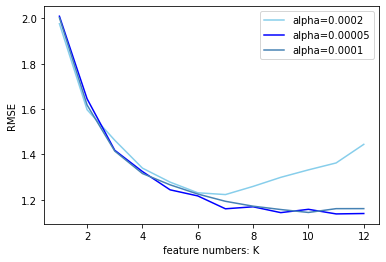

In [550]:
rmse_plot([rmse2,rmse5,rmse7],['alpha=0.0002','alpha=0.00005','alpha=0.0001'])

In [549]:
#store rmse
#rmse_df=pd.DataFrame({'rmse1':rmse1,'rmse2':rmse2,'rmse3':rmse3,'rmse4':rmse4,'rmse5':rmse5,'rmse6':rmse6,'rmse7':rmse7})
#rmse_df.to_csv('.././output/rmse_df.csv',index=None)

## Application

In [540]:
P,Q,cost,loss = MF_SGD(df_train_0,max_iter=1000,lamda=0.01,K=8,alpha=0.00005)

In [ ]:
#pd.DataFrame(P).to_csv('.././output/P.csv')
#pd.DataFrame(Q).to_csv('.././output/Q.csv')

In [541]:
rmse_final=RMSE(P,Q,df_test)
rmse_final

1.164497536702035

### Recommendation for Users

Get rating matrix for user u

$$\hat R_{u\cdot}=P_{u\cdot}Q_{\cdot i}$$

Filtered the rated movie and sorted the rating 

In [604]:
def get_movie(movieIndex):
    ## input
    # movieIndex range(0,9724)
    
    #Returns
    #title of the movie
    title=[]
    cat=[]
    for i in movieIndex:
        title.append(movies.iloc[i,1])
        cat.append(movies.iloc[i,2])
    df=pd.DataFrame({'title':title,'category':cat})
    return df

In [472]:
def recommend_topN(M, P, Q, user_id, N = 5):
    ## input
    # M (n*m matrix) is the rating matrix(fill with 0)
    # P, Q 
    # user_id is the id of user you want to recommend to
    # N is the number of movies you want to recommend
    
    ## Returns
    # recommended_movies, is the index of movies you want to recommend to user
    M_array = np.array(M)[user_id,:]
    
    already_seen = []
    recommended_movies = []
    for i in range(len(M_array)):
        if(M_array[i]>0):
            already_seen.append(i)
    predicted_ratings = np.dot(P[user_id,:],Q)
    index = np.argsort(predicted_ratings)
    for i in index:
        if(i not in already_seen):
            recommended_movies.append(i)
        if(len(recommended_movies)>=N):
            break
    return get_movie(recommended_movies)

### Movie Example:

In [605]:

recommend_topN(df_train_0, P, Q, user_id=300, N = 5)


,title,category
0,St. Vincent (2014),Comedy
1,Robin Hood: Prince of Thieves (1991),Adventure|Drama
2,"Polar Express, The (2004)",Adventure|Animation|Children|Fantasy|IMAX
3,Volga - Volga (1938),Comedy|Musical
4,Maniac Cop 2 (1990),Action|Horror|Thriller


In [606]:
a=df_train_0[300,:]
m=(np.where(a==np.max(a)))
get_movie(m)

,title,category
0,"1051 Crucible, The (1996) 2058 Assassina...",1051 Drama 2058 Action|D...


### Recommendation Based on Movie Similarity

In [475]:
def recommend_similar_movies(Q, movie_id, N = 5):
    ## input
    # P, Q 
    # movie_id is the index of movie 
    # N is the number of movies you want to recommend
    
    ## Returns
    # recommended_movies, index of movies you find similar to Q
    recommended_movies = []
    cos_distances = np.zeros(Q.shape[1])
    for i in range(Q.shape[1]):
        cos_distances[i] = np.dot(Q[:,movie_id].T, Q[:,i])/(np.linalg.norm(Q[:,movie_id]) * np.linalg.norm(Q[:,i]))
    index = np.argsort(cos_distances)
    for i in index:
        if(i!= movie_id):
            recommended_movies.append(i)
        if(len(recommended_movies)>=N):
            break
    return get_movie(recommended_movies)

### Movie Example:

In [590]:
movies[movies.title.str.contains("Happy Feet")]

,movieId,title,genres
6347,49274,Happy Feet (2006),Adventure|Animation|Children|Comedy|IMAX
7761,91386,Happy Feet Two (2011),Animation|Children|Comedy|IMAX


In [607]:
movie_search=movies[movies.title.str.contains("Happy Feet")]
movie_id=movie_search.index[0]
(movie_search)
recommend_similar_movies(Q,movie_id,10)

,title,category
0,Forgotten Silver (1996),Comedy|Documentary
1,The Hairdresser (2010),Comedy|Drama
2,I Am a Sex Addict (2005),Comedy|Documentary|Romance
3,Everything You Always Wanted to Know About Sex...,Comedy
4,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
5,Manchester by the Sea (2016),Drama
6,"Invisible Man, The (1933)",Horror|Sci-Fi
7,"All Dogs Christmas Carol, An (1998)",Animation|Children|Comedy|Musical
8,Jarhead (2005),Action|Drama|War
9,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
